In [2]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [3]:
df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

In [4]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [5]:
feature_dict

{0: 'sepal length in cm',
 1: 'sepal width in cm',
 2: 'petal length in cm',
 3: 'petal width in cm'}

In [6]:
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']

In [7]:
df.columns

Index(['sepal length in cm', 'sepal width in cm', 'petal length in cm',
       'petal width in cm', 'class label'],
      dtype='object')

In [8]:
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

In [9]:
df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [13]:
X = df.drop(['class label'], axis=1).values
y = df['class label'].values


In [14]:
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

In [15]:
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

In [16]:
# Histograms and feature selection

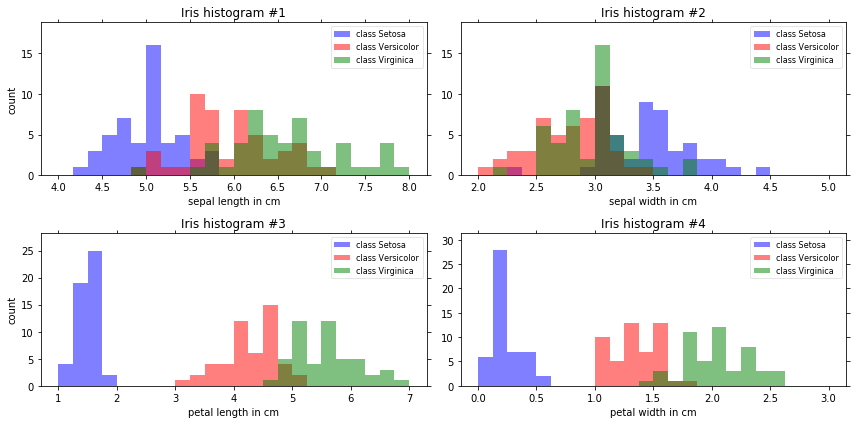

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins  = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab, col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
#     ax.spines["top"].set_visible(False)  
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       


- the petal lengths and widths are likely better suited as potential features two separate between the three flower classes. 


# Step 1: Computing the d-dimensional mean vectors

- start with a simple computation of the mean vectors $m_i$, (i=1,2,3) of the 3 different flower classes:

$ m_i = \begin{bmatrix}
\mu_{\omega_i (\text{sepal length)}}\\
\mu_{\omega_i (\text{sepal width})}\\
\mu_{\omega_i (\text{petal length)}}\\
\mu_{\omega_i (\text{petal width})}\\
\end{bmatrix}$ , with  i = 1,2,3

In [18]:
np.set_printoptions(precision=4)

mean_vectors = []

for cl in range(1, 4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



# Step 2: Computing the Scatter Matrices

### 2.1 Within-class scatter matrix $S_W$

Now, we will compute the two 4x4-dimensional matrices: 
- The within-class and 
- the between-class scatter matrix.

$ \Large S_W = \sum\limits_{i=1}^{c}  S_i$

$ \Large S_i = \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb m_i)\;(\pmb x - \pmb m_i)^T $

(scatter matrix for every class) and $m_i$ is the mean vector 



In [19]:
for i in zip(range(1,4), mean_vectors):
    print(i)

(1, array([5.006, 3.418, 1.464, 0.244]))
(2, array([5.936, 2.77 , 4.26 , 1.326]))
(3, array([6.588, 2.974, 5.552, 2.026]))


In [20]:
S_W = np.zeros((4, 4))

for cl, mv in zip(range(1, 4), mean_vectors):
    class_sc_mat = np.zeros((4, 4))                       # scatter matrix for every class
    
    for row in X[y == cl]:
        row, mv       = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row - mv).dot((row - mv).T)
        
    S_W += class_sc_mat                                   # sum class scatter matrices
    
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


### 2.2 Between-class scatter matrix $S_B$
$ \Large S_B =  \sum\limits_{i=1}^{c} N_{i} (\pmb m_i - \pmb m) (\pmb m_i - \pmb m)^T$

Here, m is the overall mean that is computed, including samples from all classes.

In [21]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))

for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    
    mean_vec = mean_vec.reshape(4,1)         # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


# Step 3: Solving the generalized eigenvalue problem for the matrix $S_W^{-1} S_B$

In [22]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.8767]
 [-0.2456]
 [-0.2107]
 [-0.356 ]]
Eigenvalue 3: -7.61e-16

Eigenvector 4: 
[[-0.7968]
 [ 0.4107]
 [ 0.4176]
 [-0.1483]]
Eigenvalue 4: 3.67e-15


# Step 4: Selecting linear discriminants for the new feature subspace

#### 4.1. Sorting the eigenvectors by decreasing eigenvalues

Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.

In [23]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972982
0.2775668638400559
3.668801765648684e-15
7.606986544516927e-16


In [24]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)

for i, j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


The first eigenpair is by far the most informative one, and we won’t loose much information if we would form a 1D-feature spaced based on this eigenpair.

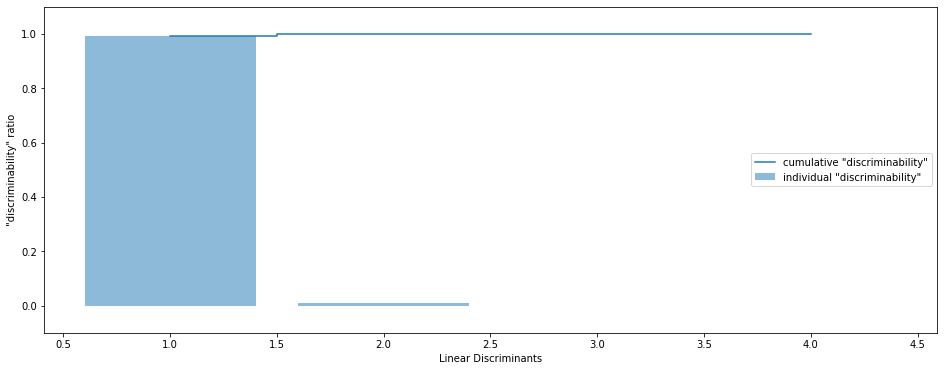

In [25]:
##### 
tot = sum(eig_vals.real)

discr = [(i / tot) for i in sorted(eig_vals.real, reverse=True)]

cum_discr = np.cumsum(discr)

plt.figure(figsize=(16, 6))
plt.bar( range(1, 5), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 5), cum_discr, where='mid', label='cumulative "discriminability"')

plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best');

As we can see in the resulting figure, the first two linear discriminants capture
about 100 percent of the useful information

#### 4.2. Choosing k eigenvectors with the largest eigenvalues

After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our k×d-dimensional eigenvector matrix W (here 4×2: based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [26]:
W = np.hstack((eig_pairs[0][1].reshape(4, 1), 
               eig_pairs[1][1].reshape(4, 1)))

print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


# Step 5: Transforming the samples onto the new subspace

In the last step, we use the 4×2-dimensional matrix W that we just computed to transform our samples onto the new subspace via the equation

Y = X × W.

(where X is a n×d-dimensional matrix representing the n samples, and Y are the transformed n×k-dimensional samples in the new subspace).

In [91]:
X_lda = X.dot(W)
assert X_lda.shape == (150, 2), "The matrix is not 150x2 dimensional."

In [27]:
def plot_step_lda():

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:, 0].real[y == label],
                    y=X_lda[:, 1].real[y == label],
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label]
                    )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", 
                    which="both", 
                    bottom="off", 
                    top="off",  
                    labelbottom="on", 
                    left="off", 
                    right="off", 
                    labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout


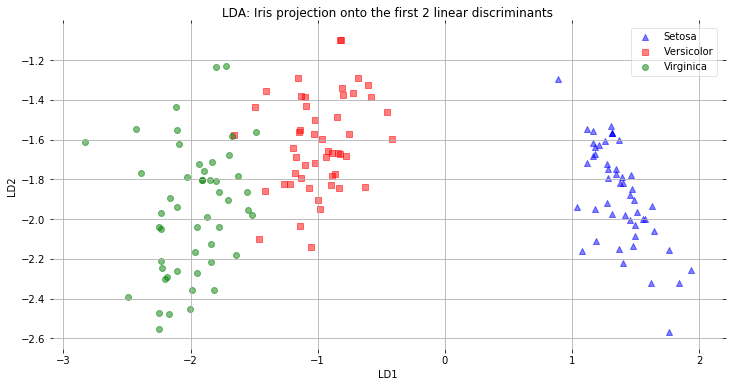

In [62]:
# plot the samples using the reduced dimensions
plot_step_lda()

The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant “LD1” separates the classes quite nicely. However, the second discriminant, “LD2”, does not add much valuable information, which we’ve already concluded when we looked at the ranked eigenvalues is step 4.

# A comparison of PCA and LDA

In [63]:
sklearn_pca = sklearnPCA(n_components=2)

X_pca = sklearn_pca.fit_transform(X)

In [64]:
def plot_pca():

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()


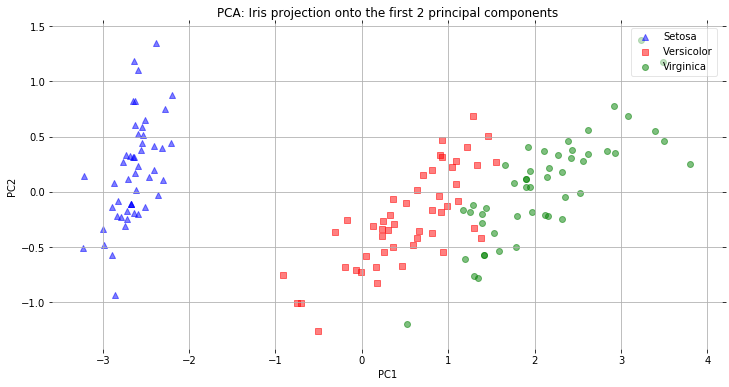

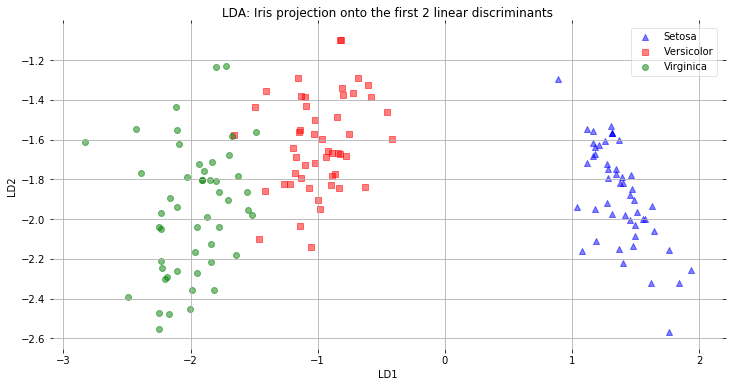

In [34]:
plot_pca()
plot_step_lda()

PCA accounts for the most variance in the whole dataset, the LDA gives us the axes that account for the most variance between the individual classes.

# LDA via scikit-learn

In [92]:
# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [93]:
def plot_scikit_lda(X, title):

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout


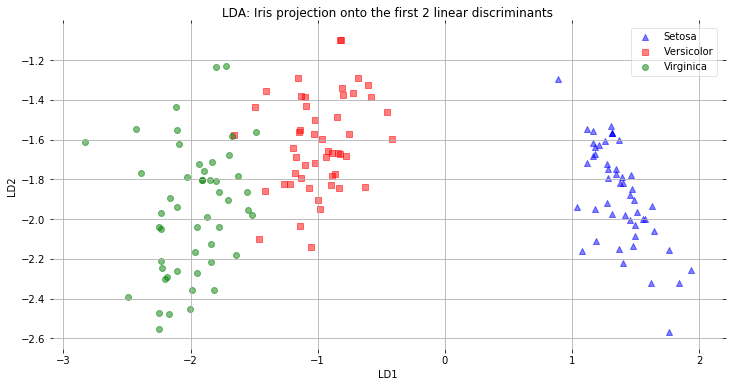

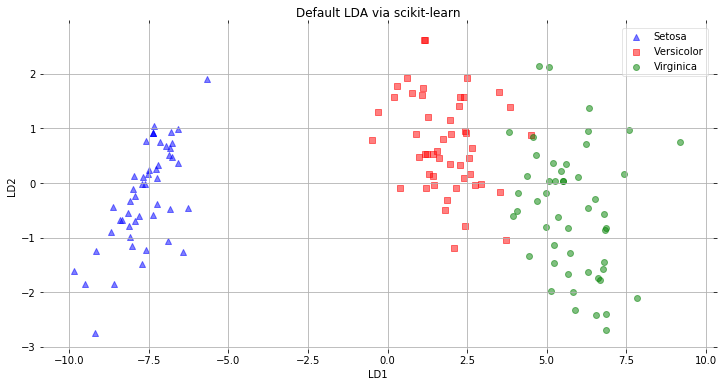

In [37]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')

feature scaling such as [standardization] does not change the overall results of an LDA and thus may be optional. 

Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. 

However, the important part is that the eigenvalues will be exactly the same as well as the final projects – the only difference you’ll notice is the scaling of the component axes

# Home work

1. Train test split
2. choose 2 LDA
3. Prediction